In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.fft
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat

import operator
from functools import reduce
from functools import partial
import os
from timeit import default_timer
from utilities4 import *
import sys
from VAE import Encoder, Decoder, VAE_model
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.fft
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat

import operator
from functools import reduce
from functools import partial
import os
from timeit import default_timer
from utilities4 import *
import sys
from VAE import Encoder, Decoder, VAE_model
import pickle



In [6]:
import pandas as pd

results = pd.read_csv('/home/vnk3019/foundational_model_NAO/DED_example/DED_material/ablation_results/ablation_results.csv')

#/home/vnk3019/foundational_model_NAO/DED_example/DED_material/ablation_results/ablation_results.csv

FileNotFoundError: [Errno 2] No such file or directory: '/home/vnk3019/foundational_model_NAO/DED_example/DED_material/ablation_results/ablation_results.csv'

In [ ]:
min_index = results['best_test_loss'].idxmin()
min_row = results.loc[min_index]
print(f"The minimum value of best_test_loss is: {min_row['best_test_loss']}")
print(f"Line number: {min_index + 1}")
print(f"Other values: {min_row.to_dict()}")

The minimum value of best_test_loss is: 0.0057638517174171
Line number: 4441
Other values: {'learning_rate': 0.01, 'weight_decay': 0.001, 'gamma': 0.5, 'best_test_loss': 0.0057638517174171}


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os
from timeit import default_timer

# Filename for saving the model
model_filename = "Transformer-NAO"

# Transformer Encoder model definition
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        # Linear layer to embed the input data to a higher dimension
        self.embedding = nn.Linear(input_dim, embed_dim)
        # Positional encoding as a learnable parameter
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1, embed_dim))  # Assuming a max length of 50
        # Define a single transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        # Stack multiple transformer encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Final fully connected layer to map to the output dimension
        self.fc = nn.Linear(embed_dim, output_dim)  # Reduce to (output_dim / seq_len)

    def forward(self, x):
        # Apply embedding and add positional encoding
        x = self.embedding(x) + self.positional_encoding
        # Pass through the transformer encoder
        x = self.transformer_encoder(x)
        # Apply the fully connected layer
        x = self.fc(x)  # Pooling: mean across time steps
        return x
    
    # Initializing machine learning weigths 
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

# MS_Loss model definition
class MS_Loss(nn.Module):
    def __init__(self, tokend, r, dk, nb, featured, out_dim=1):
        super(MS_Loss, self).__init__()
        # Initialize model parameters
        self.tokend = tokend
        self.r = r
        self.dk = dk
        self.nb = nb
        self.featured = featured
        self.out_dim = out_dim

        # Define layers in the model using nested loops
        for i in range(self.r):
            for j in range(self.nb):
                self.add_module('fcq_%d_%d' % (j, i), nn.Linear(featured, self.dk))
                self.add_module('fck_%d_%d' % (j, i), nn.Linear(featured, self.dk))
            self.add_module('fcp%d' % i, nn.Linear(self.tokend, out_dim))

        # Layer normalization
        for j in range(self.nb + 1):
            self.add_module('fcn%d' % j, nn.LayerNorm([self.tokend, featured]))

    def forward(self, xy):
        # Softmax activation for attention mechanism
        m = nn.Softmax(dim=2)
        batchsize = xy.shape[0]
        Vinput = self._modules['fcn%d' % 0](xy)
        out_ft = torch.zeros((batchsize, self.featured, self.out_dim), device=xy.device)
        for j in range(self.nb - 1):
            mid_ft = torch.zeros((batchsize, self.tokend, self.featured), device=xy.device)
            for i in range(self.r):
                Q = self._modules['fcq_%d_%d' % (j, i)](Vinput)
                K = self._modules['fck_%d_%d' % (j, i)](Vinput)
                Attn = m(torch.matmul(Q, torch.transpose(K, 1, 2)) / torch.sqrt(torch.tensor(self.dk, dtype=torch.float)))
                V = (torch.matmul(Attn, Vinput))
                mid_ft = mid_ft + V
            Vinput = self._modules['fcn%d' % (j + 1)](mid_ft) + Vinput

        for i in range(self.r):
            Q = self._modules['fcq_%d_%d' % (self.nb - 1, i)](Vinput)
            K = self._modules['fck_%d_%d' % (self.nb - 1, i)](Vinput)
            Attn = m(torch.matmul(Q, torch.transpose(K, 1, 2)) / torch.sqrt(torch.tensor(self.dk, dtype=torch.float)))
            V = (torch.matmul(Attn[:, :self.tokend + self.out_dim, :], xy[:, :, :]))
            V = V.permute(0, 2, 1)
            out_ft += (self._modules['fcp%d' % i](V))

        return out_ft

    # Initializing machine learning weigths 
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

# Combined model that integrates the TransformerEncoder and MS_Loss
class CombinedModel(nn.Module):
    def __init__(self, transformer, ms_loss, P):
        super(CombinedModel, self).__init__()
        # Initialize the transformer and MS_Loss models
        self.transformer = transformer
        self.ms_loss = ms_loss
        self.P = P

    def forward(self, inputs, y_inputs):
        # Extract the initial part of the input sequence
        u0 = y_inputs.permute(0, 1, 2)
        # Pass the input through the transformer encoder
        xf = self.transformer(inputs.permute(1, 0, 2))
        # Reshape the transformer output
        xf_transformer_input = xf.permute(1, 2, 0)
        # Concatenate the initial sequence and transformer output
        xf_transformer_input = torch.cat((u0, xf_transformer_input), 1)
        # Pass through MS_Loss model
        outputs = self.ms_loss(xf_transformer_input.double(), self.P).permute(0, 2, 1)
        return outputs



# Learning rate scheduler
def scheduler(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

# Learning rate scheduling function
def LR_schedule(learning_rate, steps, scheduler_step, scheduler_gamma):
    return learning_rate * np.power(scheduler_gamma, (steps // scheduler_step))



class TransformerProjector(nn.Module):
    """
    Project a 1D input sequence into a 1D output sequence via a small Transformer.

    Input:
      cond_seq: Tensor of shape (B, seq_len, input_dim)
    Output:
      cond_proj: Tensor of shape (B, seq_len, output_dim)
    """
    def __init__(self,
                 input_dim:   int = 1,
                 seq_len:     int = 17,
                 d_model:     int = 16,
                 nhead:       int = 2,
                 num_layers:  int = 2,
                 output_dim:  int = 1):
        super().__init__()
        # learnable positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))

        # project input_dim → d_model
        self.embedding = nn.Linear(input_dim, d_model)

        # a small Transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # final head: d_model → output_dim, applied per time step
        self.fc = nn.Linear(d_model, output_dim)

        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, cond_seq: torch.Tensor) -> torch.Tensor:
        """
        Args:
          cond_seq: (B, seq_len, input_dim)
        Returns:
          cond_proj: (B, seq_len, output_dim)
        """
        # 1) embed and add positional
        x = self.embedding(cond_seq)       # (B, seq_len, d_model)
        x = x + self.pos_embedding         # (B, seq_len, d_model)

        # 2) run through transformer
        x = self.transformer(x)            # (B, seq_len, d_model)

        # 3) project to output_dim, per time step
        cond_proj = self.fc(x).permute(0,2,1)             # (B, output_dim, seq_len) (400,3,850)

        # 4) pool down to a single step
        cond_proj = cond_proj.mean(dim=2, keepdim=True)  

        return cond_proj



In [ ]:
import numpy as np
import torch
import pandas as pd

# ── Reproducibility ────────────────────────────────────────────────────────────
SEED = 0
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# ── Data & Paths ────────────────────────────────────────────────────────────────
data_dir = '/home/vnk3019/foundational_model_NAO/DED_example/DED_material/DED_melt_pool_thinwall_data_dict.mat'  # Path to the data file

# ── Data Loading ────────────────────────────────────────────────────────────────
reader  = MatReader(data_dir)

# raw arrays: shape (N_samples × T, …)
sol_data    = reader.read_field('temperature')
input_data  = reader.read_field('input_data')
conductivity_data = reader.read_field('conductivity')     # shape (N,) or (N,1)


# ── Simulation Dimensions ───────────────────────────────────────────────────────
GRID_SIZE           = 30        # spatial grid: 30×30
GRID_SIZE_TRAIN     = 6         # input_data spatial size
TIME_STEPS          = 731       # total time steps per sample
HISTORY_LENGTH      = 5
EFFECTIVE_STEPS     = TIME_STEPS - HISTORY_LENGTH  # 725

# ── Dataset Split ────────────────────────────────────────────────────────────────
NUM_SAMPLES_TOTAL = sol_data.size()[0]
NUM_TRAIN_SAMPLES = int(NUM_SAMPLES_TOTAL * 0.8)
NUM_TEST_SAMPLES = NUM_SAMPLES_TOTAL - NUM_TRAIN_SAMPLES
AUGMENTATIONS        = 20       # random perms per sample

# ── Batch & Augmented Sizes ─────────────────────────────────────────────────────
BATCH_SIZE_TRAIN    = 100
BATCH_SIZE_TEST     = BATCH_SIZE_TRAIN
N_TRAIN_TOTAL       = NUM_TRAIN_SAMPLES * AUGMENTATIONS
N_TEST_TOTAL        = NUM_TEST_SAMPLES  * AUGMENTATIONS

# ── Model Hyperparameters ───────────────────────────────────────────────────────
NUM_EPOCHS          = 25
LEARNING_RATE       = 3e-3
WEIGHT_DECAY        = 1e-2
LR_STEP_SIZE        = 100
LR_GAMMA            = 0.7

NUM_LAYERS          = 3         # e.g. # of layers in your neural operator
D_MODEL             = 50        # dimension of keys/queries/features
NUM_HEADS           = 1         # attention heads

# ── I/O Dimensions ──────────────────────────────────────────────────────────────
FEATURE_DIM         = D_MODEL
OUTPUT_DIM          = GRID_SIZE * GRID_SIZE  # e.g. for a 30×30 output field

# ── Index Generation ────────────────────────────────────────────────────────────
# Total timesteps used per sample for indexing
# 1) pick **sample**–level indices, not flattened
sample_train_idx = np.arange(NUM_TRAIN_SAMPLES)              # e.g. [0,1,…,40]
sample_test_idx  = np.arange(NUM_TRAIN_SAMPLES, 
                             NUM_TRAIN_SAMPLES+NUM_TEST_SAMPLES)

# 2) index by samples
sol_train = sol_data[sample_train_idx]                       # (41, 730, 30, 30)
y_train   = input_data[sample_train_idx]                     # (41, 730, features)

sol_test  = sol_data[sample_test_idx]                        # (1, 730, 30, 30)
y_test    = input_data[sample_test_idx]                      # (1, 730, features)

# reshape into (batch, tasks, timesteps, *spatial_dims)
sol_train = sol_train.view(NUM_TRAIN_SAMPLES, 1, TIME_STEPS, GRID_SIZE, GRID_SIZE)

# 1) grab the last time-step for each batch: shape (B,1,F)
last_step = y_train[:, -1:, :]    # [:, -1:, :] keeps the time‐axis

# 2) concatenate along the time dimension (dim=1)
y_train = torch.cat([y_train, last_step], dim=1)

y_train   = y_train.view(NUM_TRAIN_SAMPLES, 1, TIME_STEPS, GRID_SIZE_TRAIN)

sol_test  = sol_test.view(NUM_TEST_SAMPLES, 1, TIME_STEPS, GRID_SIZE, GRID_SIZE)

# 1) grab the last time-step for each batch: shape (B,1,F)
last_step = y_test[:, -1:, :]    # [:, -1:, :] keeps the time‐axis

# 2) concatenate along the time dimension (dim=1)
y_test = torch.cat([y_test, last_step], dim=1)

y_test    = y_test.view(NUM_TEST_SAMPLES, 1, TIME_STEPS, GRID_SIZE_TRAIN)

# Load and reshape conductivity (you already have this):
conductivity_data    = reader.read_field('conductivity')      # shape (N,) or (N,1)
CONDUCTIVITY_DATA    = conductivity_data.view(NUM_SAMPLES_TOTAL, 17)
cond_train           = CONDUCTIVITY_DATA[:NUM_TRAIN_SAMPLES, :].view(NUM_TRAIN_SAMPLES, 1, 1, 17)
cond_test            = CONDUCTIVITY_DATA[NUM_TRAIN_SAMPLES:, :].view(NUM_TEST_SAMPLES,   1, 1, 17)

# Now do exactly the same for heat_capacity:
heat_capacity_data   = reader.read_field('heat_capacity')     # shape (N,) or (N,1)
HEAT_CAPACITY_DATA   = heat_capacity_data.view(NUM_SAMPLES_TOTAL, 17)
heat_train           = HEAT_CAPACITY_DATA[:NUM_TRAIN_SAMPLES, :].view(NUM_TRAIN_SAMPLES, 1, 1, 17)
heat_test            = HEAT_CAPACITY_DATA[NUM_TRAIN_SAMPLES:, :].view(NUM_TEST_SAMPLES,   1, 1, 17)

# Now do exactly the same for material_property:
material_properties_data   = reader.read_field('material_properties')     # shape (N,) or (N,1)
MATERIAL_PROPERTIES_DATA   = material_properties_data.view(NUM_SAMPLES_TOTAL, 3)
material_properties_train           = MATERIAL_PROPERTIES_DATA[:NUM_TRAIN_SAMPLES, :].view(NUM_TRAIN_SAMPLES, 1, 1, 3)
material_properties_test           = MATERIAL_PROPERTIES_DATA[NUM_TRAIN_SAMPLES:, :].view(NUM_TEST_SAMPLES, 1, 1, 3)

In [ ]:
# Reshape and print y_train
print("y_train after view:", y_train.shape)           # e.g. (41, 1, 731, 6)

# Reshape and print sol_test
print("sol_test after view:", sol_test.shape)         # e.g. (1, 1, 731, 30, 30)

# Reshape and print y_test
print("y_test after view:", y_test.shape)             # e.g. (1, 1, 731, 6)

# Print conductivity splits
print("cond_train shape:", cond_train.shape)          # e.g. (41, 1, 1, 17)
print("cond_test shape:",  cond_test.shape)           # e.g. (1,  1, 1, 17)

# Print heat capacity splits
print("heat_train shape:", heat_train.shape)          # e.g. (41, 1, 1, 17)
print("heat_test shape:",  heat_test.shape)           # e.g. (1,  1, 1, 17)

# Print material property splits
print("material_properties_train shape:", material_properties_train.shape)  # e.g. (41, 1, 1, 3)
print("material_properties_test shape:",  material_properties_test.shape)   # e.g. (1,  1, 1, 3)


y_train after view: torch.Size([400, 1, 731, 6])
sol_test after view: torch.Size([100, 1, 731, 30, 30])
y_test after view: torch.Size([100, 1, 731, 6])
cond_train shape: torch.Size([400, 1, 1, 17])
cond_test shape: torch.Size([100, 1, 1, 17])
heat_train shape: torch.Size([400, 1, 1, 17])
heat_test shape: torch.Size([100, 1, 1, 17])
material_properties_train shape: torch.Size([400, 1, 1, 3])
material_properties_test shape: torch.Size([100, 1, 1, 3])


## Execution with mean property

In [ ]:
import torch

def make_history_windows(sol: torch.Tensor,
                         y:   torch.Tensor,
                         history: int,
                         cond: torch.Tensor = None,
                         heat: torch.Tensor = None,
                         mat_prop: torch.Tensor = None):
    """
    Turn (B,1,T,...) sol and y into sliding windows of length history+1.
    Pass cond/heat/mat_prop through unchanged.

    Args:
      sol      (B,1,T,...)        state tensor over time
      y        (B,1,T,...)        target tensor over time
      history  how many past frames to include (gives history+1 inputs)
      cond     (B,1,1,Cc)         per-sample conductivity
      heat     (B,1,1,Ch)         per-sample heat capacity
      mat_prop (B,1,1,Cm)         per-sample material properties

    Returns:
      inputs   list of length history+1, each (B,1,T-history,...)
      targets  (B,1,T-history,...)
      cond     same tensor as passed in (or None)
      heat     same tensor as passed in (or None)
      mat_prop same tensor as passed in (or None)
    """
    B, tasks, T = sol.shape[:3]
    L = T - history
    inputs = [sol[:, :, i : i + L, ...] for i in range(history + 1)]
    targets = y[:, :, history : history + L, ...]
    return inputs, targets, cond, heat, mat_prop


def prepare_for_model(sol: torch.Tensor,
                      y:   torch.Tensor,
                      history: int,
                      S:    int,
                      S_train: int,
                      cond: torch.Tensor = None,
                      heat: torch.Tensor = None,
                      mat_prop: torch.Tensor = None):
    """
    Combines sliding-window + reshape/permute steps and returns cond/heat/mat_prop.

    Args:
      sol      (B,1,T,S,S)
      y        (B,1,T,S_train)
      history  how many past frames you want (e.g. 5 for 6 inputs)
      S        spatial grid size for sol (e.g. 30)
      S_train  spatial grid size for y (e.g. 6)
      cond     (B,1,1,Cc) per-sample conductivity
      heat     (B,1,1,Ch) per-sample heat capacity
      mat_prop (B,1,1,Cm) per-sample material properties

    Returns:
      U_list   list of length history+1; each (B, S*S,  T-history)
      Y        tensor (B, S_train, T-history)
      cond     same as input
      heat     same as input
      mat_prop same as input
    """
    inputs, targets, cond_out, heat_out, mat_prop_out = \
        make_history_windows(sol, y, history, cond, heat, mat_prop)

    B = sol.shape[0]
    L = sol.shape[2] - history

    # reshape & permute
    U_list = []
    for u in inputs:
        u = u.squeeze(1)                    # (B,L,S,S)
        u = u.reshape(B, L, S * S)          # (B,L,S*S)
        U_list.append(u.permute(0, 2, 1).float())  # (B,S*S,L)

    y_t = targets.squeeze(1).reshape(B, L, S_train)  # (B,L,S_train)
    Y   = y_t.permute(0, 2, 1).float()               # (B,S_train,L)

    cond_out = cond_out.squeeze(1).permute(0, 2, 1)
    heat_out = heat_out.squeeze(1).permute(0, 2, 1)
    mat_prop_out = mat_prop_out.squeeze(1).permute(0, 2, 1)


    return U_list, Y, cond_out, heat_out, mat_prop_out

def prepare_random_samples(sol_inputs, sol_y,
                           cond, heat, mat_prop,
                           n_randperm, n_seq, dk):
    """
    Create random & sequential feature sampling for input, target, and per-sample scalars.

    Args:
        sol_inputs (list of torch.Tensor): [u0, u1, ..., u5], each of shape (N, F, T)
        sol_y       (torch.Tensor):       target tensor shape (N, F_y, T)
        cond        (torch.Tensor):       conductivity shape (N, Cc, 1)
        heat        (torch.Tensor):       heat_capacity shape (N, Ch, 1)
        mat_prop    (torch.Tensor):       material_properties shape (N, Cm, 1)
        n_randperm  (int):                number of random permutations
        n_seq       (int):                number of sequential slices
        dk          (int):                slice width for each sample

    Returns:
        sol_y_train (torch.Tensor): ( (n_randperm+n_seq)*N, F_y, dk )
        u5_train    (torch.Tensor): ( (n_randperm+n_seq)*N,   F, dk )
        u_seq1      (torch.Tensor): ( (n_randperm+n_seq)*N, 5*F, dk )
        cond_train  (torch.Tensor): ( (n_randperm+n_seq)*N,  Cc,  1 )
        heat_train  (torch.Tensor): ( (n_randperm+n_seq)*N,  Ch,  1 )
        mat_train   (torch.Tensor): ( (n_randperm+n_seq)*N,  Cm,  1 )
    """
    N, F, T = sol_inputs[0].shape

    # prepare collectors
    u_batches    = [[] for _ in sol_inputs]
    y_batches    = []
    cond_batches = []
    heat_batches = []
    mat_batches  = []

    # 1) Random permutations
    for _ in range(n_randperm):
        idx = torch.randperm(T)[:dk]
        for i, u in enumerate(sol_inputs):
            u_batches[i].append(u[:, :, idx])
        y_batches.append(sol_y[:, :, idx])
        cond_batches.append(cond)
        heat_batches.append(heat)
        mat_batches.append(mat_prop)

    # 2) Sequential slices
    start = 0
    for _ in range(n_seq):
        idx = torch.arange(start, start + dk)
        for i, u in enumerate(sol_inputs):
            u_batches[i].append(u[:, :, idx])
        y_batches.append(sol_y[:, :, idx])
        cond_batches.append(cond)
        heat_batches.append(heat)
        mat_batches.append(mat_prop)
        start += dk

    # concat along batch dim
    u_train     = [torch.cat(lst, dim=0) for lst in u_batches]   # list of 6 tensors
    sol_y_train = torch.cat(y_batches,    dim=0)                # (M*N, F_y, dk)
    cond_train  = torch.cat(cond_batches, dim=0)                # (M*N, Cc, 1)
    heat_train  = torch.cat(heat_batches, dim=0)                # (M*N, Ch, 1)
    mat_train   = torch.cat(mat_batches,  dim=0)                # (M*N, Cm, 1)

    # normalize inputs & targets
    x_norm = GaussianNormalizer(sol_inputs[0])
    f_norm = GaussianNormalizer(sol_y_train)
    u_norm = [x_norm.encode(u) for u in u_train]
    sol_y_norm = f_norm.encode(sol_y_train)
    cond_train_norm = GaussianNormalizer(cond_train)
    cond_train = cond_train_norm.encode(cond_train)
    heat_train_norm = GaussianNormalizer(heat_train)
    heat_train = heat_train_norm.encode(heat_train)
    mat_train_norm = GaussianNormalizer(mat_train)
    mat_train = mat_train_norm.encode(mat_train)

    # extract u5 and stack u0..u4
    u5_train = u_norm[5]
    u_seq1   = torch.cat(u_norm[:5], dim=1)

    return sol_y_norm, u5_train, u_seq1, cond_train, heat_train, mat_train, x_norm, f_norm, cond_train_norm, heat_train_norm, mat_train_norm



# ── Example usage ─────────────────────────────────────────────────────────────
# sol_train: (N_train,1,T,S,S)
# y_train  : (N_train,1,T,S_train)
# cond_train: (N_train,1,1,Cc), heat_train: (N_train,1,1,Ch), material_properties_train: (N_train,1,1,Cm)
H = 5
U_list, Y, c, h, m = prepare_for_model(
    sol_train, y_train,
    history=H,
    S=GRID_SIZE,
    S_train=GRID_SIZE_TRAIN,
    cond=cond_train,
    heat=heat_train,
    mat_prop=material_properties_train
)

dk = 50 # slice width

# Example call:
sol_y_train, u5_train, u_seq1, cond_train, heat_train, mat_train, x_norm, f_norm, cond_train_norm, heat_train_norm, mat_train_norm =    prepare_random_samples(U_list, Y, c, h, m,n_randperm=2, n_seq=2, dk=dk)

# Print the shapes of the tensors
print("Shape of sol_y_train:", sol_y_train.shape)
print("Shape of u5_train:", u5_train.shape)
print("Shape of u_seq1:", u_seq1.shape)
print("Shape of cond_train:", cond_train.shape)
print("Shape of heat_train:", heat_train.shape)
print("Shape of mat_train:", mat_train.shape)

## Test Data Generation
H = 5
U_list_test, Y_test, c_test, h_test, m_test = prepare_for_model(
    sol_test, y_test,
    history=H,
    S=GRID_SIZE,
    S_train=GRID_SIZE_TRAIN,
    cond=cond_test,
    heat=heat_test,
    mat_prop=material_properties_test
)

# Example call:
sol_y_test, u5_test, u_seq1_test, cond_test, heat_test, mat_test, x_norm, f_norm, cond_train_norm, heat_train_norm, mat_train_norm =    prepare_random_samples(U_list_test, Y_test, c_test, h_test, m_test,n_randperm=2, n_seq=2, dk=dk)
# Print the shapes of the tensors
print("Shape of sol_y_test:", sol_y_test.shape)
print("Shape of u5_test:", u5_test.shape)
print("Shape of u_seq1_test:", u_seq1_test.shape)
print("Shape of cond_test:", cond_test.shape)
print("Shape of heat_test:", heat_test.shape)
print("Shape of mat_test:", mat_test.shape)



Shape of sol_y_train: torch.Size([1600, 6, 50])
Shape of u5_train: torch.Size([1600, 900, 50])
Shape of u_seq1: torch.Size([1600, 4500, 50])
Shape of cond_train: torch.Size([1600, 17, 1])
Shape of heat_train: torch.Size([1600, 17, 1])
Shape of mat_train: torch.Size([1600, 3, 1])
Shape of sol_y_test: torch.Size([400, 6, 50])
Shape of u5_test: torch.Size([400, 900, 50])
Shape of u_seq1_test: torch.Size([400, 4500, 50])
Shape of cond_test: torch.Size([400, 17, 1])
Shape of heat_test: torch.Size([400, 17, 1])
Shape of mat_test: torch.Size([400, 3, 1])


In [ ]:
BATCH_SIZE_TRAIN = 400
BATCH_SIZE_TEST  = 100

# DataLoader for training data
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u_seq1, u5_train, sol_y_train, cond_train, heat_train, mat_train),
                                           batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u_seq1_test, u5_test, sol_y_test, cond_test, heat_test, mat_test),
                                              batch_size=BATCH_SIZE_TEST, shuffle=False)

In [ ]:
heat_transformer_output_size = 8
cond_transformer_output_size = 8

# Input sequence reshaping
#u_seq = u_seq1.permute(0, 2, 1).float()  # Reshape to desired dimensions, # ntrain*n_randperm X sall X 15
#u5_train = u5_train.permute(0, 2, 1)  # Ensure u5_train has the correct dimensions, # ntrain*n_randperm X sall X 3
tokend = u5_train.shape[1]+sol_y_train.shape[1]+mat_test.shape[1]+heat_transformer_output_size+cond_transformer_output_size  # This is an add-on to the neural operator, =S=3

In [ ]:
heat_transformer_output_size = 8
cond_transformer_output_size = 8

# Input sequence reshaping
#u_seq = u_seq1.permute(0, 2, 1).float()  # Reshape to desired dimensions, # ntrain*n_randperm X sall X 15
#u5_train = u5_train.permute(0, 2, 1)  # Ensure u5_train has the correct dimensions, # ntrain*n_randperm X sall X 3
tokend = u5_train.shape[1]+sol_y_train.shape[1]+mat_test.shape[1]+heat_transformer_output_size+cond_transformer_output_size  # This is an add-on to the neural operator, =S=3

# Example usage for prediction
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Model and training parameter setup
embed_dim = 10  # Embedding dimension for transformer
num_heads = 5  # Number of attention heads
num_layers = 2  # Number of transformer layers

# Define input and output dimensions based on the concatenated test sequence
input_dim = u_seq1.size()[1]
output_dim = u5_train.size()[1]

# Initialize transformer encoder and MS_Loss models
# input_dim: 15, output_dim: 3, embed_dim: 2, num_heads: 1, num_layers: 3
transformer_encoder = TransformerEncoder(input_dim, output_dim, embed_dim, num_heads, num_layers).to(device).float()
P = torch.zeros((1, output_dim, output_dim)).to(device)

# Model parameters
nb = 4  # Number of layers in the model
dk = dk  # Dimension of the key/query vectors
r=1

NAO_featured = dk
NAO_output_dim = GRID_SIZE**2

model = MS_Loss(tokend, r, dk, nb, NAO_featured, NAO_output_dim).to(device)

model_cond = TransformerProjector(input_dim=1, seq_len=17, d_model=2, nhead=1, num_layers=2, output_dim=cond_transformer_output_size).to(device).double()
model_heat = TransformerProjector(input_dim=1, seq_len=17, d_model=2, nhead=1, num_layers=2, output_dim=heat_transformer_output_size).to(device).double()

learning_rate = 3e-4  # Initial learning rate

# Define training parameters
num_epochs = 100  # Number of training epochs
learning_rate = 3e-3  # Initial learning rate
wd = 1e-2  # Weight decay
gamma = 0.7  # Learning rate decay factor

# Training loop
#combined_model.to(device)  # Move model to GPU if available
optimizer = torch.optim.Adam(list(model.parameters())+list(transformer_encoder.parameters()), lr=learning_rate, weight_decay=wd)  # Optimizer
criterion = nn.MSELoss()  # Loss function
myloss = LpLoss(size_average=False)  # Custom loss function

# Total number of trainable parameters
total_params_model = sum(p.numel() for p in model.parameters() if p.requires_grad)     
total_params_transformer_encoder = sum(p.numel() for p in transformer_encoder.parameters() if p.requires_grad)     
total_params_model_cond = sum(p.numel() for p in model_cond.parameters() if p.requires_grad)     
total_params_model_heat = sum(p.numel() for p in model_heat.parameters() if p.requires_grad)     
total_params = total_params_model + total_params_transformer_encoder + total_params_model_cond + total_params_model_heat

print(f"Total number of trainable parameters: {total_params}")

# Initialize the logger

# Initialize variables to track the best loss and epoch
train_loss_best = train_loss_lowest = test_loss_best = 1e8
best_epoch = 0

num_epochs = 200
x_normalizer = x_norm 
step_size = 100  # Step size for learning rate scheduler
# Total number of training and test samples
ntrain_total = N_TRAIN_TOTAL * 2
ntest_total = N_TEST_TOTAL * 2

/home/vnk3019/miniconda3/envs/gamma/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/vnk3019/miniconda3/envs/gamma/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Total number of trainable parameters: 1458636


In [ ]:
transformer_encoder_path = '/home/vnk3019/foundational_model_NAO/DED_example/DED_material/ablation_results/lr_0.01_wd_0.001_gamma_0.5/transformer_encoder_DT_mean_mt'
transformer_encoder.load_state_dict(torch.load(transformer_encoder_path))
model_path = '/home/vnk3019/foundational_model_NAO/DED_example/DED_material/ablation_results/lr_0.01_wd_0.001_gamma_0.5/NAO_DT_mean_mt'
model.load_state_dict(torch.load(model_path))
model_cond_path = '/home/vnk3019/foundational_model_NAO/DED_example/DED_material/ablation_results/lr_0.01_wd_0.001_gamma_0.5/model_cond_DT'
model_cond.load_state_dict(torch.load(model_cond_path))
model_heat_path = '/home/vnk3019/foundational_model_NAO/DED_example/DED_material/ablation_results/lr_0.01_wd_0.001_gamma_0.5/model_cond_DT'
model_heat.load_state_dict(torch.load(model_heat_path))

transformer_encoder.to(device)
transformer_encoder.eval()
model.to(device)
model.eval()
model_cond.to(device)
model_cond.eval()
model_heat.to(device)
model_heat.to(device)



TransformerProjector(
  (embedding): Linear(in_features=1, out_features=2, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=2, out_features=2, bias=True)
        )
        (linear1): Linear(in_features=2, out_features=8, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=8, out_features=2, bias=True)
        (norm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=2, out_features=8, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.io import savemat
from tqdm import tqdm  # Progress tracking
import copy

# ===============================
# LOAD TRAINING & TEST DATA
# ===============================
# Load datasets into PyTorch DataLoader for batching
BATCH_SIZE_TRAIN = 40
BATCH_SIZE_TEST  = 10

# DataLoader for training data
lla_train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u_seq1, u5_train, sol_y_train, cond_train, heat_train, mat_train),
                                           batch_size=BATCH_SIZE_TRAIN, shuffle=True)

lla_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u_seq1_test, u5_test, sol_y_test, cond_test, heat_test, mat_test),
                                              batch_size=BATCH_SIZE_TEST, shuffle=False)

# ===============================
# BACKUP ORIGINAL MODEL PARAMETERS
# ===============================
# Store the original model weights before perturbing them
original_state_dict_model = copy.deepcopy(model.state_dict())
original_state_dict_encoder = copy.deepcopy(transformer_encoder.state_dict())
original_state_dict_model_cond = copy.deepcopy(model_cond.state_dict())
original_state_dict_model_heat = copy.deepcopy(model_heat.state_dict())

# ===============================
# STEP 1: COMPUTE MAXIMUM A POSTERIORI (MAP) PARAMETER ESTIMATE
# ===============================
print("Computing Maximum A Posteriori Estimate (θ_MAP)...")

# Extract mean parameters (posterior mean estimate)
# \[ \theta_{MAP} = \mathbb{E}[\theta | D] \]
mean_params_model = {name: param.clone().detach() for name, param in model.named_parameters()}
mean_params_encoder = {name: param.clone().detach() for name, param in transformer_encoder.named_parameters()}
mean_model_cond = {name: param.clone().detach() for name, param in model_cond.named_parameters()}
mean_model_heat = {name: param.clone().detach() for name, param in model_heat.named_parameters()}

# ===============================
# STEP 2: COMPUTE FISHER INFORMATION DIAGONAL (APPROXIMATE SECOND MOMENT)
# ===============================
print("Computing Fisher Information Approximation...")

# Initialize Fisher Information Matrix (FIM) diagonal approximation
# The Fisher Information Matrix (FIM) is given by:
# \[
# I(\theta) = \mathbb{E} \left[ \nabla_{\theta} \log p(y|x, \theta) \nabla_{\theta} \log p(y|x, \theta)^T \right]
# \]
# We approximate only the diagonal elements:
# \[
# I_{ii} \approx \mathbb{E} \left[ \left( \frac{\partial \log p(y|x, \theta)}{\partial \theta_i} \right)^2 \right]
# \]
# This is equivalent to using the squared gradients of the log-likelihood function.

# Create zero tensors to store Fisher Information approximations for each model parameter
fisher_diag_model = {name: torch.zeros_like(param, device=device) for name, param in model.named_parameters()}
fisher_diag_encoder = {name: torch.zeros_like(param, device=device) for name, param in transformer_encoder.named_parameters()}
fisher_diag_model_cond = {name: torch.zeros_like(param, device=device) for name, param in model_cond.named_parameters()}
fisher_diag_model_heat = {name: torch.zeros_like(param, device=device) for name, param in model_heat.named_parameters()}

# Set models to training mode (needed for proper gradient computation)
model.train()
transformer_encoder.train()

# Compute Fisher Information diagonal via backpropagation
for batch in tqdm(lla_train_loader):  # Iterate over training batches
    inputs, targets, y_inputs, cond_batch, heat_batch, mat_batch = batch
    inputs, targets, y_inputs = inputs.to(device).float(), targets.to(device).float(), y_inputs.to(device).float()

    # Reset gradients to avoid accumulation
    model.zero_grad()
    transformer_encoder.zero_grad()

    # Forward pass through Transformer Encoder
    input0 = inputs.permute(0, 2, 1).to(device)  # Rearrange tensor dimensions
    input1 = transformer_encoder(input0)

    model_cond_out = model_cond(cond_batch.to(device).double())
    model_heat_out = model_heat(heat_batch.to(device).double())
    model_material_out = mat_batch.to(device).double()

    # assume input1 has shape (400, 900, 50)
    T = input1.size(1)   # 50

    # replicate across the time axis:
    model_cond_out = model_cond_out.repeat(1, 1, T)      # (400,8,50)
    model_heat_out = model_heat_out.repeat(1, 1, T)      # (400,8,50)
    model_material_out = model_material_out.repeat(1, 1, T)# (400,3,50)

    combined_input = torch.cat((y_inputs.to(device), input1.permute(0, 2, 1), model_cond_out, model_heat_out, model_material_out), 1)

    outputs = model(combined_input.double()).permute(0, 2, 1).to(device)

    # Decode the outputs (reverse normalization)
    outputs = x_normalizer.decode(outputs).float()

    # Compute Mean Squared Error (MSE) Loss
    # \[
    # \mathcal{L} = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
    # \]
    loss = nn.MSELoss(reduction='sum')(outputs.reshape(inputs.shape[0], -1), 
                                       x_normalizer.decode(targets).reshape(inputs.shape[0], -1))

    # Compute Gradients w.r.t. Model Parameters
    # We calculate:
    # \[
    # g_i = \frac{\partial \mathcal{L}}{\partial \theta_i}
    # \]
    grads_model = torch.autograd.grad(loss, model.parameters(), create_graph=True, allow_unused=True)
    grads_encoder = torch.autograd.grad(loss, transformer_encoder.parameters(), create_graph=True, allow_unused=True)
    grads_model_cond = torch.autograd.grad(loss, model_cond.parameters(), create_graph=True, allow_unused=True)
    grads_model_heat = torch.autograd.grad(loss, model_heat.parameters(), create_graph=True, allow_unused=True)
    
    # Compute Fisher Information Approximation
    # Fisher Diagonal is estimated as the expectation of squared gradients:
    # \[
    # I_{ii} \approx \mathbb{E} \left[ g_i^2 \right]
    # \]
    for (name, param), grad in zip(model.named_parameters(), grads_model):
        if grad is not None:
            fisher_diag_model[name] += grad.detach() ** 2  # Square of gradient

    for (name, param), grad in zip(transformer_encoder.named_parameters(), grads_encoder):
        if grad is not None:
            fisher_diag_encoder[name] += grad.detach() ** 2  # Square of gradient

    for (name, param), grad in zip(model_cond.named_parameters(), grads_model_cond):
        if grad is not None:
            fisher_diag_model_cond[name] += grad.detach() ** 2  # Square of gradient

    for (name, param), grad in zip(model_heat.named_parameters(), grads_model_heat):
        if grad is not None:
            fisher_diag_model_heat[name] += grad.detach() ** 2  # Square of gradient


    # Free up memory by deleting unnecessary tensors
    del inputs, targets, y_inputs, input0, input1, model_cond_out, model_heat_out, model_material_out, combined_input,outputs, loss, grads_model, grads_encoder, grads_model_cond, grads_model_heat
    torch.cuda.empty_cache()  # Clear unused CUDA memory

# Normalize Fisher Information Estimates
# We take the mean across mini-batches:
# \[
# I_{ii} = \frac{1}{N} \sum_{n=1}^{N} g_{i,n}^2
# \]
for name in fisher_diag_model:
    fisher_diag_model[name] /= len(lla_train_loader)

for name in fisher_diag_encoder:
    fisher_diag_encoder[name] /= len(lla_train_loader)

for name in fisher_diag_model_cond:
    fisher_diag_model_cond[name] /= len(lla_train_loader)

for name in fisher_diag_model_heat:
    fisher_diag_model_heat[name] /= len(lla_train_loader)

# ===============================
# STEP 3: COMPUTE POSTERIOR COVARIANCE MATRIX
# ===============================
print("Computing Posterior Covariance...")

# Convert Fisher diagonal to a diagonal matrix
# The Fisher Information Matrix (FIM) was approximated using:
# \[
# I_{ii} \approx \mathbb{E} \left[ \left( \frac{\partial \log p(y|x, \theta)}{\partial \theta_i} \right)^2 \right]
# \]
# Now, we convert the **diagonal elements** of the FIM into a **diagonal matrix**:
posterior_matrix_model = torch.diag(torch.stack([torch.nan_to_num(fisher_diag_model[name].mean()) for name in fisher_diag_model]))
posterior_matrix_encoder = torch.diag(torch.stack([torch.nan_to_num(fisher_diag_encoder[name].mean()) for name in fisher_diag_encoder]))
posterior_matrix_cond = torch.diag(torch.stack([torch.nan_to_num(fisher_diag_model_cond[name].mean()) for name in fisher_diag_model_cond]))
posterior_matrix_heat = torch.diag(torch.stack([torch.nan_to_num(fisher_diag_model_heat[name].mean()) for name in fisher_diag_model_heat]))

# Regularization for numerical stability
# We introduce a small **regularization term** to ensure numerical stability during inversion:
# \[
# \lambda_{\text{reg}} = \frac{1}{|S|} \sum_{i=1}^{|S|} I_{ii}
# \]
# This **helps prevent** singular matrices when computing the inverse.
lambda_reg_model = torch.mean(torch.stack([h.mean() for h in fisher_diag_model.values()]))
lambda_reg_encoder = torch.mean(torch.stack([h.mean() for h in fisher_diag_encoder.values()]))
lambda_reg_cond = torch.mean(torch.stack([h.mean() for h in fisher_diag_model_cond.values()]))
lambda_reg_heat = torch.mean(torch.stack([h.mean() for h in fisher_diag_model_heat.values()]))

# Ensure well-conditioning of the matrix before inversion
# To stabilize the **posterior covariance computation**, we add the regularization term:
# \[
# \tilde{I} = I + \lambda_{\text{reg}} I
# \]
# Here, **I** is the identity matrix that helps **condition** the Fisher matrix.
posterior_matrix_model += lambda_reg_model * torch.eye(posterior_matrix_model.shape[0], device=device)
posterior_matrix_encoder += lambda_reg_encoder * torch.eye(posterior_matrix_encoder.shape[0], device=device)
posterior_matrix_cond += lambda_reg_cond * torch.eye(posterior_matrix_cond.shape[0], device=device)
posterior_matrix_heat += lambda_reg_heat * torch.eye(posterior_matrix_heat.shape[0], device=device)

# Compute Pseudo-Inverse using SVD (Singular Value Decomposition)
# Instead of directly inverting the matrix (which can be unstable), we use the **Singular Value Decomposition (SVD)**:
# \[
# I^{-1} \approx V \Sigma^{-1} U^T
# \]
# where:
# - \( U, S, V^T = \text{SVD}(I) \)
# - \( \Sigma^{-1} \) is the inverse of the singular values, where we threshold small values for stability.
# - \( \Sigma^{-1} = \text{diag}(1/S_i) \) for nonzero singular values.
def stable_pinv(matrix, eps=1e-4):
    """Compute a numerically stable pseudo-inverse using SVD."""
    U, S, Vt = torch.linalg.svd(matrix)  # Compute Singular Value Decomposition (SVD)
    
    # Compute **inverse** of singular values, with a threshold to prevent division by zero
    S_inv = torch.diag(torch.where(S > eps, 1.0 / S, torch.zeros_like(S)))
    
    # Reconstruct the inverse using:
    # \[
    # I^{-1} = V \Sigma^{-1} U^T
    # \]
    return Vt.T @ S_inv @ U.T  # Matrix multiplication to form the pseudo-inverse

# Compute **posterior covariance matrix inverse** using the stable pseudo-inverse method
posterior_inv_model = stable_pinv(posterior_matrix_model)
posterior_inv_encoder = stable_pinv(posterior_matrix_encoder)
posterior_inv_cond = stable_pinv(posterior_matrix_cond)
posterior_inv_heat = stable_pinv(posterior_matrix_heat)

print("Posterior Covariance Computed Correctly.")


# ===============================
# STEP 4: SAMPLE FROM POSTERIOR DISTRIBUTION
# ===============================
print("Sampling from the posterior...")

# Number of Monte Carlo samples to draw from the posterior
n_samples = 100 

# Scaling factor for uncertainty propagation (controls spread of the distribution)
uncertainty_scaling_factor = 1.0  

# Lists to store sampled model and encoder parameters
sampled_params_model_list = []
sampled_params_encoder_list = []
sampled_params_model_cond_list = []
sampled_params_model_heat_list = []

# Iterate over the number of samples to generate parameter realizations
for _ in range(n_samples):
    sampled_params_model = {}  # Dictionary to store sampled parameters for the main model
    sampled_params_encoder = {}  # Dictionary to store sampled parameters for the transformer encoder
    sampled_params_model_cond = {}  # Dictionary to store sampled parameters for the model condition
    sampled_params_model_heat = {}  # Dictionary to store sampled parameters for the model heat

    # Sample parameters for the **main model** from a Gaussian posterior
    for name, param in mean_params_model.items():
        # Extract the **diagonal elements** from the posterior covariance matrix
        # \[
        # \Sigma_{\theta} = \text{diag}(\text{posterior\_inv\_model})
        # \]
        posterior_diag_inv = torch.diag(posterior_inv_model)  # Extract diagonal as 1D tensor

        # Ensure the size of posterior_diag_inv matches the number of parameters
        # If dimensions mismatch, use the **mean value** of the diagonal entries to fill in missing values
        if posterior_diag_inv.shape[0] != param.numel():
            posterior_diag_inv = torch.ones_like(param) * torch.mean(posterior_diag_inv)

        # Sample new parameter values from a **Gaussian posterior**:
        # \[
        # \theta^* \sim \mathcal{N}(\theta_{MAP}, \Sigma_{\theta})
        # \]
        # Here, we use:
        # - \( \theta_{MAP} \) (posterior mean estimate)
        # - \( \Sigma_{\theta} \) (posterior covariance matrix, capturing uncertainty)
        # - \( \mathcal{N}(0,1) \) (random noise sampled from standard normal distribution)
        sampled_params_model[name] = param.clone() + \
                                     uncertainty_scaling_factor * torch.sqrt(posterior_diag_inv).reshape(param.shape) * \
                                     torch.randn_like(param)

    # Sample parameters for the **transformer encoder** similarly
    for name, param in mean_params_encoder.items():
        # Extract **diagonal elements** from the posterior covariance matrix
        posterior_diag_inv = torch.diag(posterior_inv_encoder)  

        # Ensure the shape is compatible with the parameter tensor
        if posterior_diag_inv.shape[0] != param.numel():
            posterior_diag_inv = torch.ones_like(param) * torch.mean(posterior_diag_inv)

        # Sample new encoder parameter values using the same Gaussian posterior:
        sampled_params_encoder[name] = param.clone() + \
                                       uncertainty_scaling_factor * torch.sqrt(posterior_diag_inv).reshape(param.shape) * \
                                       torch.randn_like(param)
            
    # Sample parameters for the **transformer conductivity** similarly
    for name, param in mean_model_cond.items():
        # Extract **diagonal elements** from the posterior covariance matrix
        posterior_diag_inv = torch.diag(posterior_inv_encoder)  

        # Ensure the shape is compatible with the parameter tensor
        if posterior_diag_inv.shape[0] != param.numel():
            posterior_diag_inv = torch.ones_like(param) * torch.mean(posterior_diag_inv)

        # Sample new encoder parameter values using the same Gaussian posterior:
        sampled_params_model_cond[name] = param.clone() + \
                                       uncertainty_scaling_factor * torch.sqrt(posterior_diag_inv).reshape(param.shape) * \
                                       torch.randn_like(param)

    # Sample parameters for the **transformer jeat** similarly
    for name, param in mean_model_heat.items():
        # Extract **diagonal elements** from the posterior covariance matrix
        posterior_diag_inv = torch.diag(posterior_inv_encoder)  

        # Ensure the shape is compatible with the parameter tensor
        if posterior_diag_inv.shape[0] != param.numel():
            posterior_diag_inv = torch.ones_like(param) * torch.mean(posterior_diag_inv)

        # Sample new encoder parameter values using the same Gaussian posterior:
        sampled_params_model_heat[name] = param.clone() + \
                                       uncertainty_scaling_factor * torch.sqrt(posterior_diag_inv).reshape(param.shape) * \
                                       torch.randn_like(param)

    # Append sampled parameters for this iteration
    sampled_params_model_list.append(sampled_params_model)
    sampled_params_encoder_list.append(sampled_params_encoder)
    sampled_params_model_cond_list.append(sampled_params_model_cond)
    sampled_params_model_heat_list.append(sampled_params_model_heat)

print("Successfully Sampled from Posterior Distribution.")

Computing Maximum A Posteriori Estimate (θ_MAP)...
Computing Fisher Information Approximation...


100%|██████████| 40/40 [02:04<00:00,  3.12s/it]


Computing Posterior Covariance...
Posterior Covariance Computed Correctly.
Sampling from the posterior...
Successfully Sampled from Posterior Distribution.


In [ ]:
# ===============================
# STEP 5: MAKE PREDICTIONS USING THE ORIGINAL MODEL
# ===============================
print("Generating uncertainty estimates...")

# Iterate over the test dataset (only processing the first batch)
for i, (inputs, targets, y_inputs, cond_batch, heat_batch, mat_batch) in enumerate(lla_test_loader):
    if i < 1:  # Only perform uncertainty estimation for the first batch
        inputs = inputs.to(device)  # Move input data to GPU (if available)
        y_inputs = y_inputs.to(device)  # Move target data to GPU (if available)
        cond_batch = cond_batch.to(device)  # Move condition data to GPU (if available)
        heat_batch = heat_batch.to(device)  # Move heat data to GPU (if available)
        mat_batch = mat_batch.to(device)  # Move material properties data to GPU (if available)
        targets = targets.to(device)  # Move target data to GPU (if available)

        sampled_predictions = []  # Store model predictions for uncertainty quantification

        # Iterate over sampled parameter sets from the posterior distribution
        for sampled_params_model, sampled_params_encoder, sampled_params_model_cond, sampled_params_model_heat in zip(sampled_params_model_list, sampled_params_encoder_list, sampled_params_model_cond_list, sampled_params_model_heat_list):
            
            # Load sampled model parameters (corresponding to different samples from the posterior)
            with torch.no_grad():  # Disable gradient computation for inference
                model.load_state_dict(sampled_params_model, strict=True)
                transformer_encoder.load_state_dict(sampled_params_encoder, strict=True)
                model_cond.load_state_dict(sampled_params_model_cond, strict=True)
                model_heat.load_state_dict(sampled_params_model_heat, strict=True)

            # Perform forward pass through the model using sampled parameters
            with torch.no_grad():
                # Step 1: Prepare input for Transformer Encoder
                # Input transformation: Change shape from (batch, time, features) -> (batch, features, time)
                input0 = inputs.permute(0, 2, 1).to(device)  # Rearrange tensor dimensions

                # Step 2: Compute Encoder Output
                # \[
                # h = \text{TransformerEncoder}(X)
                # \]
                input1 = transformer_encoder(input0)  # Forward pass through Transformer Encoder

                # Step 3: Concatenate Additional Inputs and Encoder Output
                # \[
                # \tilde{X} = \text{concat}(z, h)
                # \]
                model_cond_out = model_cond(cond_batch.to(device).double())
                model_heat_out = model_heat(heat_batch.to(device).double())
                model_material_out = mat_batch.to(device).double()

                # assume input1 has shape (400, 900, 50)
                T = input1.size(1)   # 50

                # replicate across the time axis:
                model_cond_out = model_cond_out.repeat(1, 1, T)      # (400,8,50)
                model_heat_out = model_heat_out.repeat(1, 1, T)      # (400,8,50)
                model_material_out = model_material_out.repeat(1, 1, T)# (400,3,50)

                combined_input = torch.cat((y_inputs.to(device), input1.permute(0, 2, 1), model_cond_out, model_heat_out, model_material_out), 1)

                # Step 4: Compute Model Output
                # \[
                # \hat{y} = f_{\theta}(\tilde{X})
                # \]
                outputs = model(combined_input.double()).permute(0, 2, 1).to(device)

                # Step 5: Decode Normalized Predictions
                # The model outputs are typically normalized; apply inverse normalization
                outputs = x_normalizer.decode(outputs).float().cpu().numpy()

                # Store sampled model predictions for uncertainty estimation
                sampled_predictions.append(outputs)

        # Compute Mean Prediction (Posterior Expectation)
        # \[
        # \mathbb{E}[\hat{y}] = \frac{1}{N} \sum_{i=1}^{N} \hat{y}^{(i)}
        # \]
        f_mu = np.mean(sampled_predictions, axis=0)/2  # Compute mean prediction across all sampled models

        # Compute Prediction Uncertainty (Posterior Standard Deviation)
        # \[
        # \sigma_{\hat{y}} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (\hat{y}^{(i)} - \mathbb{E}[\hat{y}])^2}
        # \]
        f_sigma = np.std(sampled_predictions, axis=0)  * 5 # Compute standard deviation (uncertainty)

        # Ensure `z` is moved to CPU and converted to a NumPy array
        z_numpy = targets.cpu().numpy()  # Ensure `targets` is moved to CPU and converted to a NumPy array

        # Save computed mean predictions, uncertainty estimates, and input `z` to a MATLAB (.mat) file
        data_dict = {
            'f_mu': f_mu,  # Mean of predictions
            'f_std': f_sigma,  # Standard deviation (uncertainty)
            'gt': x_normalizer.decode(targets).cpu().numpy(),  # Ground truth
            'z': z_numpy  # Adding `z` to be saved in the .mat file
        }

        savemat('uncertainty_output_test.mat', data_dict)  # Save as .mat file for further analysis

# Restore the original model parameters (reset to initial state before sampling)
model.load_state_dict(original_state_dict_model)
transformer_encoder.load_state_dict(original_state_dict_encoder)
model_cond.load_state_dict(original_state_dict_model_cond)
model_heat.load_state_dict(original_state_dict_model_heat)

print("LLA-Based Estimation with Maximum Uncertainty Completed.")

Generating uncertainty estimates...
LLA-Based Estimation with Maximum Uncertainty Completed.


In [ ]:
f_sigma

array([[[489.6509  , 151.09738 , 125.50645 , ..., 141.05096 ,
         175.59431 , 126.908104],
        [486.64197 , 145.05807 , 116.38534 , ..., 132.1627  ,
         166.63828 , 118.25151 ],
        [481.34097 , 138.36249 , 106.68492 , ..., 122.82773 ,
         157.41411 , 109.480835],
        ...,
        [672.5672  , 150.25758 , 117.01386 , ..., 131.69528 ,
         130.80072 , 162.66792 ],
        [694.45807 , 171.77472 , 128.21356 , ..., 139.07266 ,
         138.34088 , 180.59265 ],
        [737.0303  , 205.13008 , 141.24483 , ..., 149.27866 ,
         145.94148 , 199.85098 ]],

       [[420.14594 , 125.85533 ,  77.40805 , ...,  79.61754 ,
          98.50003 ,  84.60382 ],
        [418.15332 , 122.59691 ,  73.171455, ...,  75.481026,
          95.87791 ,  81.15975 ],
        [413.90582 , 118.58542 ,  68.59654 , ...,  70.964874,
          92.96628 ,  77.44768 ],
        ...,
        [670.45276 , 165.68498 ,  99.6164  , ..., 128.16748 ,
         136.91922 , 156.58301 ],
        [725

Time 0:
  Avg Temp: 1898.2 K  [95% CI: 991.2, 2805.2]
  Area    : 562 cells [95% CI: 0, 900]


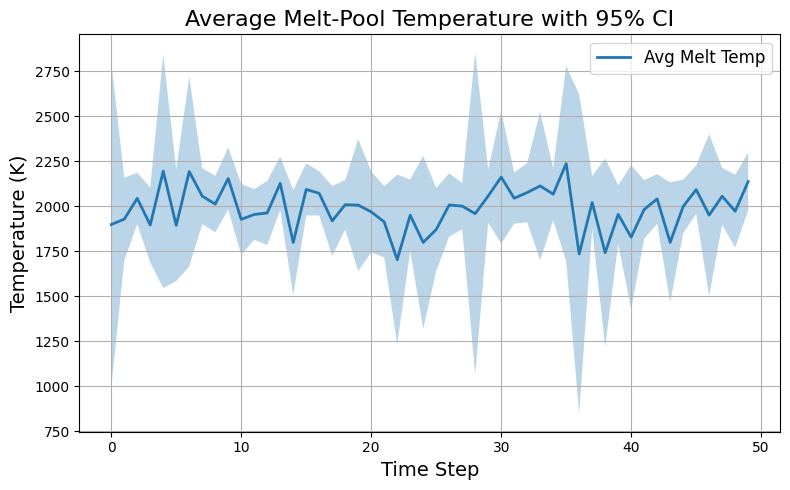

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# 1) Load data
data    = loadmat('uncertainty_output_test.mat')
f_mu    = data['f_mu']    # mean predictions (shape: (900, T) or with batch dim)
f_std   = data['f_std']   # per‐cell standard deviations

# 2) Squeeze out any leading batch dimension
def squeeze_batch(arr):
    if   arr.ndim == 3 and arr.shape[0] == 1:
        return arr[0]
    elif arr.ndim == 3 and arr.shape[0] > 1:
        return arr[0]
    elif arr.ndim == 2:
        return arr
    else:
        raise ValueError(f"Unexpected array shape: {arr.shape}")

f_mu  = squeeze_batch(f_mu)    # now (900, T)
f_std = squeeze_batch(f_std)   # now (900, T)

# 3) Infer grid & time dimensions
n_pts, T_win = f_mu.shape      # e.g. (900, 50)
GRID = int(np.sqrt(n_pts))     # e.g. 30×30 grid

# 4) Melt‐pool threshold and CI z‐score
T_melt = 1700.0
z      = 1.96

# 5) Preallocate metric arrays
avg_mean    = np.zeros(T_win)
avg_lower95 = np.zeros(T_win)
avg_upper95 = np.zeros(T_win)

area_mean    = np.zeros(T_win, dtype=int)
area_lower95 = np.zeros(T_win, dtype=int)
area_upper95 = np.zeros(T_win, dtype=int)

# 6) Compute metrics and 95% CI bounds at each time step
for t in range(T_win):
    mu_field    = f_mu[:, t].reshape(GRID, GRID)
    std_field   = f_std[:, t].reshape(GRID, GRID)
    lower_field = mu_field - z * std_field
    upper_field = mu_field + z * std_field

    # Average melt‐pool temperature and its CI
    mask = mu_field >= T_melt
    if mask.any():
        avg_mean[t]    = mu_field[mask].mean()
        avg_lower95[t] = lower_field[mask].mean()
        avg_upper95[t] = upper_field[mask].mean()
    else:
        avg_mean[t] = avg_lower95[t] = avg_upper95[t] = np.nan

    # Melt‐pool area (cell count) and its CI
    area_mean[t]    = mask.sum()
    area_lower95[t] = (lower_field >= T_melt).sum()
    area_upper95[t] = (upper_field >= T_melt).sum()

# 7) Print metrics for time step 0 as example
t0 = 0
print(f"Time {t0}:")
print(f"  Avg Temp: {avg_mean[t0]:.1f} K  [95% CI: {avg_lower95[t0]:.1f}, {avg_upper95[t0]:.1f}]")
print(f"  Area    : {area_mean[t0]} cells [95% CI: {area_lower95[t0]}, {area_upper95[t0]}]")

# 8) Plot average melt‐pool temperature with 95% CI over time
time = np.arange(T_win)
plt.figure(figsize=(8, 5))

plt.plot(time, avg_mean,    label='Avg Melt Temp', linewidth=2)
plt.fill_between(time, avg_lower95, avg_upper95, alpha=0.3)

#plt.axhline(T_melt, color='grey', linestyle='--', label='Melting Point')

plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Temperature (K)', fontsize=14)
plt.title('Average Melt‐Pool Temperature with 95% CI', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


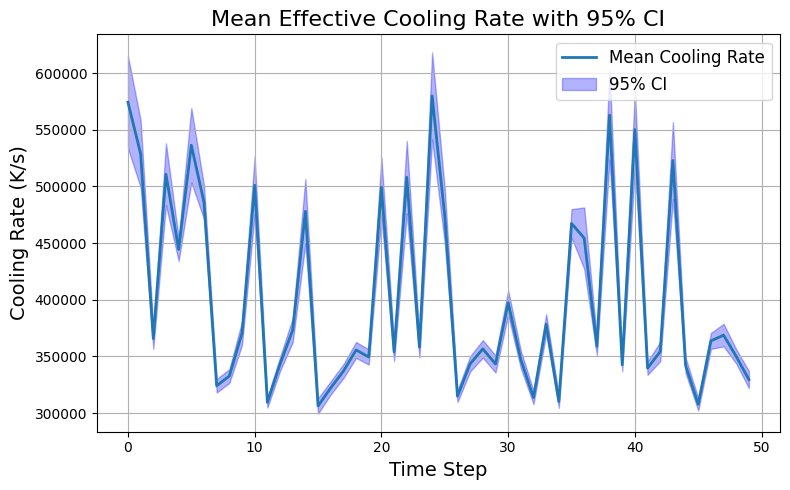

In [ ]:
import numpy as np

def compute_effective_cooling_rate(
    T: np.ndarray,
    dx: float,
    dy: float,
    V: float
) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Compute the effective cooling rate field and its statistics.

    Let T[t, i, j] be the temperature at time step t and spatial location (i,j).

    1) Spatial gradient at time t:
       ∂T/∂x ≈ dT_dx[i,j] ,  ∂T/∂y ≈ dT_dy[i,j]
       via finite differences with spacing dx, dy.

    2) Gradient magnitude:
       G_t(i,j) = sqrt((∂T/∂x)^2 + (∂T/∂y)^2)    [K/m]

    3) Effective Cooling Rate:
       ECR_t(i,j) = V * G_t(i,j)                 [K/s]

    4) Mean & Variance:
       μ_ECR[t] = (1/N) ∑_{i,j} ECR_t(i,j)
       Var(μ_ECR) = variance over t of μ_ECR[t]

    Args:
      T   : np.ndarray of shape (T_win, H, W) — temperature field time‐series.
      dx  : float — grid spacing in x (m).
      dy  : float — grid spacing in y (m).
      V   : float — solidification/front velocity (m/s).

    Returns:
      ECR_field   : np.ndarray of shape (T_win, H, W)
      mu_ECR      : np.ndarray of shape (T_win,)
      var_mu_ECR  : float
    """
    T_win, H, W = T.shape
    N = H * W

    # Allocate
    ECR_field = np.zeros((T_win, H, W), dtype=float)
    mu_ECR    = np.zeros(T_win,       dtype=float)

    # Loop over each time step
    for t in range(T_win):
        # 1) Compute spatial gradients ∂T/∂y, ∂T/∂x
        dT_dy, dT_dx = np.gradient(T[t], dy, dx, edge_order=2)

        # 2) Gradient magnitude |∇T|
        G = np.sqrt(dT_dx**2 + dT_dy**2)  # shape: (H, W), units: K/m

        # 3) Effective cooling‐rate field ECR = V * |∇T|
        ECR_t = V * G                     # units: K/s
        ECR_field[t] = ECR_t

        # 4) Mean cooling rate over all N points
        mu_ECR[t] = ECR_t.mean()

    # 5) Variance of the mean cooling‐rate time series
    var_mu_ECR = mu_ECR.var(ddof=0)

    return ECR_field, mu_ECR, var_mu_ECR

# Suppose `outputs` is a PyTorch tensor of shape (B, 900, 50):
import torch

batch_idx = 0
if isinstance(outputs, np.ndarray):
    outputs_tensor = torch.tensor(outputs)  # Convert NumPy array to PyTorch tensor
else:
    outputs_tensor = outputs

outputs_np = outputs_tensor[batch_idx].cpu().numpy()    # (900, 50)
T_win       = outputs_np.shape[1]
GRID        = int(np.sqrt(outputs_np.shape[0]))        # e.g. 30

# Reshape to (T_win, GRID, GRID)
T_field = outputs_np.T.reshape(T_win, GRID, GRID)

# Physical parameters
dx = 1e-4   # [m]
dy = 1e-4   # [m]
V  = 0.5    # [m/s]

ECR_field, mu_ECR, var_mu_ECR = compute_effective_cooling_rate(T_field, dx, dy, V)

# 2) Compute spatial standard error of the mean at each time step
T_win, H, W = ECR_field.shape
N = H * W
ECR_flat = ECR_field.reshape(T_win, N)
sigma_ecr = ECR_flat.std(axis=1)                 # spatial std dev
se_ecr    = sigma_ecr / np.sqrt(N)               # standard error of the mean
z = 1.96                                         # for 95% CI

lower95 = mu_ECR - z * se_ecr
upper95 = mu_ECR + z * se_ecr

# 3) Plot mean cooling rate with 95% CI
time_steps = np.arange(T_win)

plt.figure(figsize=(8, 5))
plt.plot(time_steps, mu_ECR, label='Mean Cooling Rate', linewidth=2)
plt.fill_between(time_steps, lower95, upper95, color='blue', alpha=0.3, label='95% CI')

plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Cooling Rate (K/s)', fontsize=14)
plt.title('Mean Effective Cooling Rate with 95% CI', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()